### Load data

In [34]:
import numpy as np
import pandas as pd

# Load data
debt_df = pd.read_csv("Debt_Series.csv")

# Filter series

# Filter series
debt_df = debt_df.rename(columns={'datadate': 'Date'})
debt_df['Date'] = pd.to_datetime(debt_df['Date']) 
debt_df = debt_df.set_index('Date')
debt_df = debt_df.sort_index() #sort by date


In [35]:
# Get correct data range for interpolation
debt_df_period = debt_df.loc["2023-09-30":"2024-12-31"]
print(debt_df_period.head())

            gvkey  fyearq  fqtr indfmt consol popsrc datafmt curcdq datacqtr  \
Date                                                                           
2023-09-30   2055    2023     3   INDL      C      D     STD    USD   2023Q3   
2023-12-31   2055    2023     4   INDL      C      D     STD    USD   2023Q4   
2024-03-31   2055    2024     1   INDL      C      D     STD    USD   2024Q1   
2024-06-30   2055    2024     2   INDL      C      D     STD    USD   2024Q2   
2024-09-30   2055    2024     3   INDL      C      D     STD    USD   2024Q3   

           datafqtr  dlcq   dlttq costat  
Date                                      
2023-09-30   2023Q3   8.0  4767.0      A  
2023-12-31   2023Q4  43.0  5180.0      A  
2024-03-31   2024Q1  12.0  4713.0      A  
2024-06-30   2024Q2  11.0  4713.0      A  
2024-09-30   2024Q3  13.0  4712.0      A  


### Linearly interpolate $L_t$

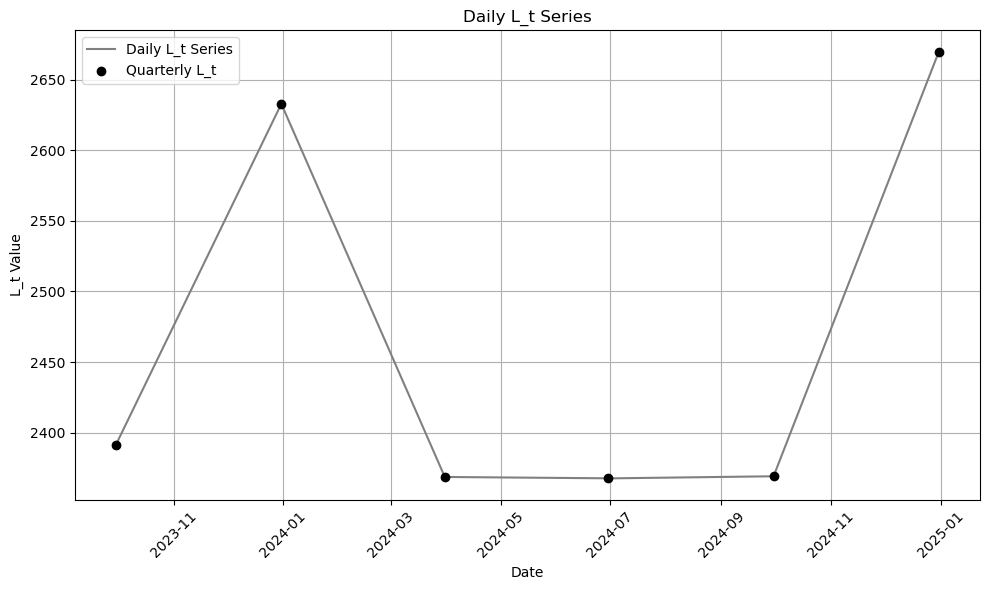

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Date is the index (already done, but just in case)
debt_df_period.index = pd.to_datetime(debt_df_period.index)

# Create a copy of debt_df_period to avoid SettingWithCopyWarning
debt_df_period_copy = debt_df_period.copy()

# Define L_t using .loc to avoid the SettingWithCopyWarning
debt_df_period_copy.loc[:, "L_t"] = debt_df_period_copy["dlcq"] + 0.5 * debt_df_period_copy["dlttq"]

# Create a daily date range covering the period of the available data
daily_dates = pd.date_range(start=debt_df_period_copy.index.min(), end=debt_df_period_copy.index.max())

# Create a daily DataFrame and join the quarterly data
daily_debt = pd.DataFrame(index=daily_dates)

# Join the quarterly L_t data to the daily DataFrame by reindexing
daily_debt = daily_debt.join(debt_df_period_copy[['L_t']])

# Perform linear interpolation only on the joined data
daily_debt['L_t'] = daily_debt['L_t'].interpolate(method='linear')

# Plotting the L_t series
plt.figure(figsize=(10, 6))

# Plot interpolated L_t daily series
plt.plot(daily_debt.index, daily_debt["L_t"], label="Daily L_t Series", color='grey')

# Plot quarterly L_t values 
plt.scatter(debt_df_period_copy.index, debt_df_period_copy["L_t"], color='black', label='Quarterly L_t', zorder=5)

# Add labels and titles
plt.title("Daily L_t Series")
plt.xlabel("Date")
plt.ylabel("L_t Value")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [37]:
print(daily_debt['L_t'].head())

2023-09-30    2391.500
2023-10-01    2394.125
2023-10-02    2396.750
2023-10-03    2399.375
2023-10-04    2402.000
Freq: D, Name: L_t, dtype: float64


### Construct market cap daily series

In [2]:
# Open file
stock_df = pd.read_excel("Crisp_daily_time_series_71298.xlsx")

# Filter series
stock_df = stock_df.rename(columns={'Names Date': 'Date'})
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df.set_index('Date')
stock_df = stock_df.sort_index()

stock_df = stock_df.loc["2023-09-30":"2024-12-31"]

print(stock_df.head())


            PERMNO  Price or Bid/Ask Average  Shares Outstanding
Date                                                            
2023-10-02   71298                     14.23             1755468
2023-10-03   71298                     14.19             1755468
2023-10-04   71298                     14.20             1755468
2023-10-05   71298                     14.37             1755468
2023-10-06   71298                     14.58             1755468


In [3]:
# Compute market cap
stock_df["Market Cap"] = stock_df["Price or Bid/Ask Average"] * stock_df["Shares Outstanding"]

# Resample to daily frequency and interpolate linearly
stock_cap_daily = stock_df[["Market Cap"]].resample("D").interpolate(method="linear")

print(stock_cap_daily)

              Market Cap
Date                    
2023-10-02  2.498031e+07
2023-10-03  2.491009e+07
2023-10-04  2.492765e+07
2023-10-05  2.522607e+07
2023-10-06  2.559472e+07
...                  ...
2024-12-27  2.740941e+07
2024-12-28  2.728122e+07
2024-12-29  2.715303e+07
2024-12-30  2.702484e+07
2024-12-31  2.709476e+07

[457 rows x 1 columns]


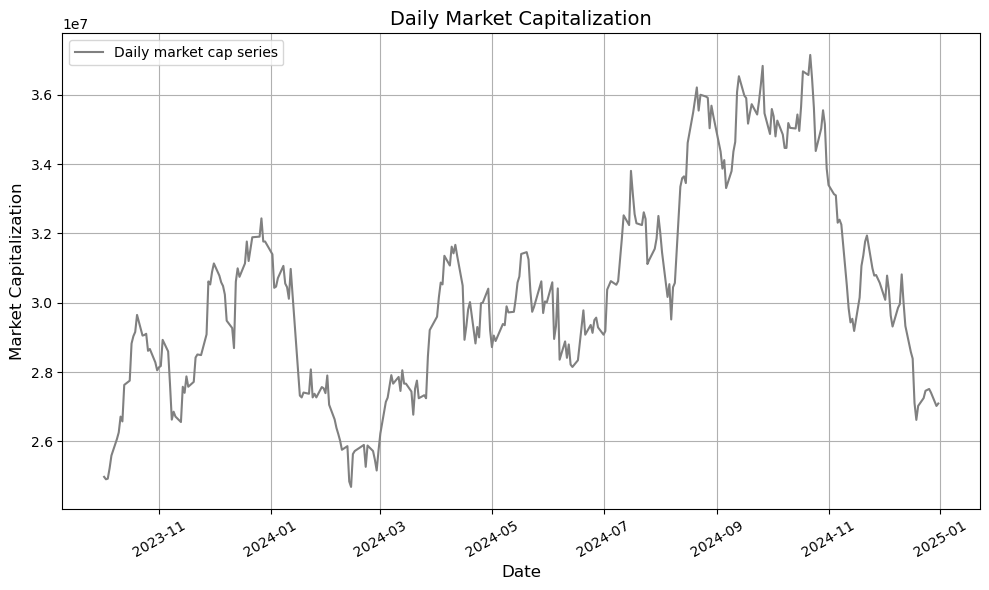

In [4]:
# Plotting the market capitalization data
plt.figure(figsize=(10, 6))

# Plot series
plt.plot(stock_cap_daily.index, stock_cap_daily['Market Cap'], label='Daily market cap series', color='grey')

# Plot characteristics
plt.title("Daily Market Capitalization", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Market Capitalization", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()

plt.show()

### Estimate asset value and volatility

First, we get the 1-month Treasury short rates from the FRED. 
Data from https://fred.stlouisfed.org/series/DGS1MO .
All NaN values are replaced by the previous NaN value for simplicity. 

In [46]:
# Load the FED short rate data
short_rate = pd.read_csv("GS1_1_year_series.csv")

# Filter and index short rate series
short_rate = short_rate.rename(columns={'observation_date': 'Date'})
short_rate['Date'] = pd.to_datetime(short_rate['Date'])
short_rate = short_rate.set_index('Date')
short_rate = short_rate.sort_index()

# Filter data for the desired time period
short_rate = short_rate.loc["2023-09-30":"2024-12-31"]

# Create a daily time index from 2023-09-30 to 2024-12-31
daily_index = pd.date_range(start="2023-10-01", end="2024-12-31", freq='D')

# Reindex the short_rate DataFrame to have daily data
short_rate_daily = short_rate.reindex(daily_index)

# Interpolate the missing values linearly
short_rate_daily['GS1'] = short_rate_daily['GS1'].interpolate(method='linear')

# Print the result
print(short_rate_daily)


                 GS1
2023-10-01  5.420000
2023-10-02  5.415484
2023-10-03  5.410968
2023-10-04  5.406452
2023-10-05  5.401935
...              ...
2024-12-27  4.230000
2024-12-28  4.230000
2024-12-29  4.230000
2024-12-30  4.230000
2024-12-31  4.230000

[458 rows x 1 columns]


In [47]:
# Ensure the 'short rate' is correctly mapped to stock_df
stock_df['short rate'] = stock_df.index.to_series().map(short_rate_daily['GS1'])
stock_df['short rate'] = stock_df['short rate'].ffill()  # Forward fill missing values
#stock_df['short rate'].fillna(5.42, inplace=True)  # Fill any remaining NaN values

print(stock_df)

            PERMNO  Price or Bid/Ask Average  Shares Outstanding  \
Date                                                               
2023-10-02   71298                     14.23             1755468   
2023-10-03   71298                     14.19             1755468   
2023-10-04   71298                     14.20             1755468   
2023-10-05   71298                     14.37             1755468   
2023-10-06   71298                     14.58             1755468   
...            ...                       ...                 ...   
2024-12-24   71298                     15.71             1748049   
2024-12-26   71298                     15.74             1748049   
2024-12-27   71298                     15.68             1748049   
2024-12-30   71298                     15.46             1748049   
2024-12-31   71298                     15.50             1748049   

              Market Cap  short rate  
Date                                  
2023-10-02  2.498031e+07    5.415484 

#### Simulate asset value and volatility using Geometric Brownian Motion (GBM)

The algorithm triggers a Monte Carlo Simulation if the end data is after the last available date in the **stock_df** dataframe. The simulation scheme is as follows: 

The next asset price using the **Geometric Brownian Motion (GBM)** model is computed as $S_{t+1} = S_t \cdot e^{\left( \mu - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \epsilon_t \sqrt{\Delta t}}$ where:
- $S_{t}$ = Current asset price
- $\mu$ = Drift (adjusted by the short rate)
- $\sigma$ = Volatility
- $\epsilon_{t} \sim N(0,1)$ = Random normal variable
- $\Delta_{t}$ = Time step (daily: $\frac{1}{252}$)


Short Rate Data (Daily):
Date
2023-10-02    0.054155
2023-10-03    0.054110
2023-10-04    0.054065
2023-10-05    0.054019
2023-10-06    0.053974
Name: short rate, dtype: float64

Initial Price: 15.5
Days to simulate: 2

Estimated Asset Value at the end of 2024: $14.68865
Estimated Asset Volatility at the end of 2024: $0.30055


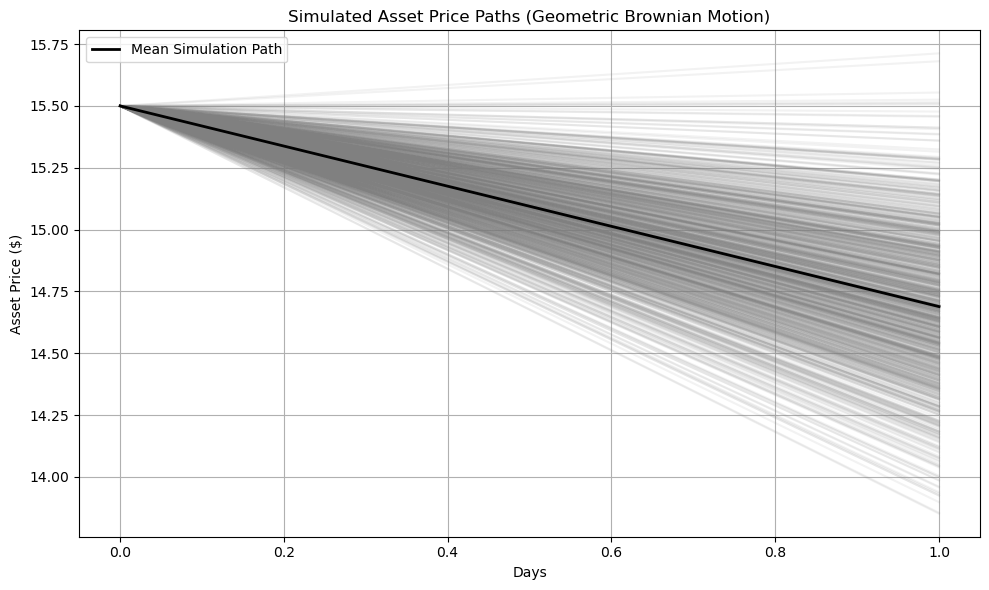

Simulation Parameters:
mean returns 0.00049
volatility or sigma 0.02074


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use the "Price or Bid/Ask Average" column as the asset price
asset_prices = stock_df["Price or Bid/Ask Average"]

# Step 2: Calculate daily returns
returns = asset_prices.pct_change().dropna()

# Step 3: Estimate drift (mu) and volatility (sigma) from historical returns
mu = returns.mean()  # Average daily return
sigma = returns.std()  # Standard deviation (volatility)

# Step 4: Use the 'short rate' from stock_df for the risk-free rate
start_date = stock_df.index[0]  # Ensure we start from the first available date
end_date = '2024-12-31'

# Filter stock_df for the desired time period
stock_df = stock_df.loc[start_date:end_date]

# Get the 'short rate' from stock_df (convert percentage to decimal)
short_rate_filtered = stock_df['short rate'] / 100  

# Check if short_rate has any missing values
print("\nShort Rate Data (Daily):")
print(short_rate_filtered.head())

# Step 5: Define parameters for the GBM model and iterative simulation
initial_price = asset_prices.iloc[-1]  # Last known price
print(f"\nInitial Price: {initial_price}")

# Get the last available date in stock_df
last_available_date = asset_prices.index[-1]

end_date = "2025-01-02" #set data after end of dataset to trigger monte carlo simulation

# Ensure end_date is after the last available date
if pd.to_datetime(end_date) <= last_available_date:
    print("Simulation is unnecessary as the end date is within the available data.")
    expected_value = initial_price  # Use last available price
    expected_volatility = sigma  # Use historical volatility
    print(f"Estimated Asset Value at the end of 2024: ${expected_value:.5f}")
    print(f"Estimated Asset Volatility at the end of 2024: ${expected_volatility:.5f}")
else:
    # Calculate the number of days to simulate
    days_to_simulate = (pd.to_datetime(end_date) - last_available_date).days
    print(f"Days to simulate: {days_to_simulate}")

    # Number of simulations
    num_simulations = 1000

    # Create an array to store simulated asset prices
    simulated_prices = np.zeros((num_simulations, days_to_simulate))

    # Step 6: Perform Monte Carlo simulation for asset price projection
    for i in range(num_simulations):
        price_path = np.zeros(days_to_simulate)
        price_path[0] = initial_price

        for t in range(1, days_to_simulate):
            # Ensure we don't go out of bounds when applying short rates
            risk_free_rate = short_rate_filtered.iloc[min(t, len(short_rate_filtered)-1)]
            
            # Generate daily return with dynamically changing short rate
            drift = mu - risk_free_rate
            random_shock = np.random.normal(0, sigma)
            price_path[t] = price_path[t-1] * np.exp(drift + random_shock)
        
        simulated_prices[i, :] = price_path

    # Step 7: Estimate the expected asset value and volatility at the end of 2024
    simulated_final_prices = simulated_prices[:, -1]
    expected_value = np.mean(simulated_final_prices)
    expected_volatility = np.std(simulated_final_prices)

    # Print results
    print(f"\nEstimated Asset Value at the end of 2024: ${expected_value:.5f}")
    print(f"Estimated Asset Volatility at the end of 2024: ${expected_volatility:.5f}")

    # Step 8: Plot the results of the simulations
    plt.figure(figsize=(10, 6))
    plt.plot(simulated_prices.T, color='grey', alpha=0.1)  # Plot all simulations
    plt.plot(np.mean(simulated_prices, axis=0), color='black', label='Mean Simulation Path', linewidth=2)  # Mean path
    plt.title('Simulated Asset Price Paths (Geometric Brownian Motion)')
    plt.xlabel('Days')
    plt.ylabel('Asset Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Display the plot
    plt.show()

print("Simulation Parameters:")
print("mean returns", round(mu,5))
print("volatility or sigma",round(sigma,5))


### Construct default frontier for all maturities (0-20 years) 

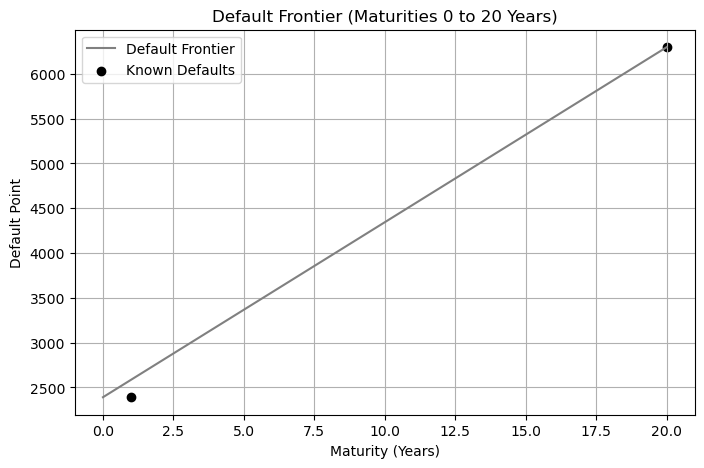

    Maturity (Years)  Default Point
0           0.000000    2391.500000
1           0.202020    2430.939394
2           0.404040    2470.378788
3           0.606061    2509.818182
4           0.808081    2549.257576
5           1.010101    2588.696970
6           1.212121    2628.136364
7           1.414141    2667.575758
8           1.616162    2707.015152
9           1.818182    2746.454545
10          2.020202    2785.893939
11          2.222222    2825.333333
12          2.424242    2864.772727
13          2.626263    2904.212121
14          2.828283    2943.651515
15          3.030303    2983.090909
16          3.232323    3022.530303
17          3.434343    3061.969697
18          3.636364    3101.409091
19          3.838384    3140.848485
20          4.040404    3180.287879


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume debt_df and daily_debt are already loaded

# Extract relevant data
L_t = daily_debt['L_t'].iloc[0]  # One-year default point (first value in L_t)
DLTTQ_t = debt_df['dlttq'].iloc[0]  # Twenty-year default point (first value in dlttq)

# Define maturity range (0 to 20 years)
maturities = np.linspace(0, 20, 100)  # 100 points for smooth interpolation

# Perform linear interpolation
L_interp = L_t + (DLTTQ_t - L_t) / 20 * maturities

# Create DataFrame for results
default_frontier_df = pd.DataFrame({'Maturity (Years)': maturities, 'Default Point': L_interp})

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(maturities, L_interp, label='Default Frontier', color='grey')
plt.scatter([1, 20], [L_t, DLTTQ_t], color='black', label='Known Defaults')
plt.xlabel('Maturity (Years)')
plt.ylabel('Default Point')
plt.title('Default Frontier (Maturities 0 to 20 Years)')
plt.legend()
plt.grid(True)
plt.show()

# Display first few rows of the interpolated data
print(default_frontier_df[:21])
